In [1]:
import os
import random
from typing import Iterable, Tuple

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import maxabs_scale
from torch.utils.data import Dataset

from utils import combine_trial_types, constants

In [2]:
class FOSData:
    """ Abstract class for optical imaging data. """
    def __init__(self):
        pass

In [3]:
class SubjectMontageData(FOSData):
    """
    Creates a representation of the FOS data set that groups subjects' dynamic
    data with their corresponding labels based on the classification task.
    Performs basic pre-processing to as specified by the input arguments.
    """
    def __init__(self, data_dir: str, subject: str, montage: str,
                 classification_task: str, n_montages: int,
                 filter_zeros: bool = False):

        self.data_dir = data_dir
        self.data = pd.DataFrame()

        # Group montages in pairs based on trial num recorded (a-b, c-d, etc.)
        if n_montages == 8:
            montages = [montage]
        elif n_montages == 4:
            paired_montages = {'a': 'A', 'b': 'A',
                               'c': 'B', 'd': 'B',
                               'e': 'C', 'f': 'C',
                               'g': 'D', 'h': 'D'}
            montages = [k for k, v in paired_montages.items() if v == montage]

        for m in montages:
            # Pandas DataFrame has format: timestep across trial numbers
            # (index), all possible channels + metadata (columns)
            temp = pd.read_parquet(
                os.path.join(data_dir, f'{subject}_{m}_0.parquet'))

            # Add channels as new features
            self.data = pd.concat([self.data, temp], axis=1)

            # Remove duplicate columns (i.e. trial_num, subject_id, etc.)
            self.data = self.data.loc[:, ~self.data.columns.duplicated()]

        # Separate DataFrame into metadata and dynamic phase data
        meta_cols = ['trial_num', 'subject_id', 'montage']
        chan_cols = [c for c in self.data.columns if 'ph_' in c]
        assert ((len(chan_cols) == 256 and n_montages == 4) or
                (len(chan_cols) == 128 and n_montages == 8))
        self.meta_data = self.data.loc[:, meta_cols]
        self.dynamic_table = self.data.loc[:, chan_cols + ['trial_num']]
        # Labels correspond to the trial type of a specific trial number
        self.labels = self.data.groupby('trial_num').mean().reset_index()[
            ['trial_num', 'trial_type']]
        self.labels.index.name = None
        self.labels = pd.DataFrame(self.labels,
                                   columns=['trial_num', 'trial_type'])

        # Filter channels by dropping channels with all zeros across all trials
        # (across train/valid/test splits)
        # Step 1: replace zeros with NaN
        # Step 2: drop columns with all NaN values
        if filter_zeros:
            self.dynamic_table.loc[:, chan_cols] = \
                self.dynamic_table.loc[:, chan_cols].replace(0, np.nan)
            self.dynamic_table = self.dynamic_table.dropna(axis=1, how='all')
        # How many viable channels remain?
        viable_chan = [c for c in self.dynamic_table.columns if 'ph_' in c]
        self.num_viable = len(viable_chan)

        # Combine trial types to get class labels
        # Classify left versus right motor response
        if classification_task == 'motor_LR':
            func = combine_trial_types.combine_motor_LR
            self.classes = 2
        # Classify stimulus modality and motor response
        elif classification_task == 'stim_motor':
            func = combine_trial_types.stim_modality_motor_LR_labels
            self.classes = 4
        # Classify response modality, stimulus modality, and response
        # polarity
        elif classification_task == 'response_stim':
            func = combine_trial_types.sresponse_stim_modality_labels
            self.classes = 8
        else:
            raise NotImplementedError('Classification task not supported')
        self.labels['label'] = self.labels['trial_type'].apply(func)
        # self.labels.rename({'trial_type': 'label'}, axis=1, inplace=True)
        self.labels = self.labels.dropna(
            axis=0, subset=['label']).copy().reset_index(drop=True)

        # NumPy arrays of trial_num, labels, and indices
        self.trial_id = self.labels.loc[:, 'trial_num'].unique()
        self.trial_types = self.labels.loc[:, 'trial_type'].values.astype(np.float32)
        self.labels = self.labels.loc[:, 'label'].values.astype(np.float32)
        self.idxs = list(range(len(self.labels)))

        # Dynamic table is a DataFrame containing trials present for the
        # specified trial type - assign corresponding idxs to match trial_id
        self.dynamic_table = self.dynamic_table.loc[
            self.dynamic_table['trial_num'].isin(self.trial_id), :
            ].reset_index(drop=True)
        trial_idx_map = dict(zip(self.trial_id, self.idxs))
        self.dynamic_table.loc[:, 'idx'] = self.dynamic_table.apply(
            lambda x: trial_idx_map[x.trial_num], axis=1)
        assert len(self.dynamic_table['trial_num'].unique()) == len(self.idxs)

    def get_num_viable_channels(self):
        return self.num_viable

In [4]:
class SubjectMontageDataset(Dataset):
    """
    Creates a PyTorch-loadable dataset that can be used for train/valid/test
    splits. Compatible with K-fold cross-validation and stratified splits.
    """
    def __init__(self, data: FOSData, subset: str = None,
                 seed: int = 42, props: Tuple[float] = (70, 10, 20),
                 stratified: bool = False, cv: int = 1, nested_cv: int = 1,
                 cv_idx: int = 0, nested_cv_idx: int = 0, seed_cv: int = 15,
                 **preprocessing):
        super().__init__()

        subsets = ['train', 'valid', 'test']
        assert subset in subsets
        assert sum(props) == 100

        self.data = data
        self.props = props
        self.proportions = dict(zip(subsets, self.props))
        self.subset = subset
        self.seed = seed
        self.seed_cv = seed_cv
        self.stratified = stratified
        self.cv = cv
        self.nested_cv = nested_cv
        self.cv_idx = cv_idx
        self.nested_cv_idx = nested_cv_idx

        self.preprocessing = preprocessing

        self.labels = self.data.labels
        self.trial_types = self.data.trial_types
        self.trial_id = self.data.trial_id
        self.dynamic_table = self.data.dynamic_table
        self.chan_cols = [c for c in self.dynamic_table.columns if 'ph_' in c]
        self.idxs = self.data.idxs

        # Stratify by class labels
        if self.stratified:

            # learn / test split
            sss_outer = StratifiedShuffleSplit(
                n_splits=self.nested_cv,
                test_size=self.proportions['test'] / 100,
                random_state=self.seed)
            learn_idx, test_idx = list(
                sss_outer.split(self.idxs, self.labels))[self.nested_cv_idx]
            learn = np.array(self.idxs)[learn_idx]
            learn_labels = self.labels[learn_idx]

            # train / valid split
            if self.cv == 1:
                sss_inner = StratifiedShuffleSplit(
                    n_splits=self.cv,
                    test_size=(
                        self.proportions['valid'] /
                        (self.proportions['train'] +
                         self.proportions['valid'])),
                    random_state=self.seed_cv)
            else:
                sss_inner = StratifiedKFold(n_splits=self.cv, shuffle=True,
                                            random_state=self.seed_cv)
            train_idx, valid_idx = list(
                sss_inner.split(learn, learn_labels))[self.cv_idx]
            train_idx = learn[train_idx]
            valid_idx = learn[valid_idx]

            if self.subset == 'train':
                self.idxs = list(train_idx)
            elif self.subset == 'valid':
                self.idxs = list(valid_idx)
            else:
                self.idxs = list(test_idx)
        else:
            if cv != 1 or nested_cv != 1:
                raise NotImplementedError(
                    'CV is not implemented without stratified split')
            if seed_cv != seed:
                raise NotImplementedError(
                    'Different seed for CV is not implemented without '
                    'stratified split')
            np.random.shuffle(self.idxs)
            if self.subset:
                self.idxs = [x for idx, x in enumerate(self.idxs)
                             if self._check_idx(idx + 1, self.subset)]

        # Filter relevent entries based on split
        self.trial_id = [self.trial_id[id_] for id_ in self.idxs]
        self.labels = self.labels[self.idxs]
        self.trial_types = self.trial_types[self.idxs]
        self.dynamic_table = self.dynamic_table.loc[
            self.dynamic_table['idx'].isin(self.idxs), :]

        # Get a list of NaN columns that require imputation
        self.nan_cols = list(
            self.dynamic_table.columns[self.dynamic_table.isna().any()])

        # Impute missing channels
        imputed_df = self.dynamic_table.copy()
        for col in self.nan_cols:
            # Subset of columns
            subset = self.dynamic_table.loc[:, [col, 'trial_num']]
            if preprocessing['imputed_signal'] is not None:
                # Use pre-calculated imputed signal on training set to imput
                for trial in subset.trial_num.unique():
                    subset_subset = subset.loc[subset['trial_num'] == trial, :]
                    if np.isnan(subset_subset[col].values[0]):
                        idxs_to_replace = subset_subset.index
                        imputed_df.loc[idxs_to_replace, col] = \
                            preprocessing['imputed_signal']

            elif preprocessing['impute'] == 'zero':
                imputed_df.loc[:, col] = subset.fillna(value=0.0)
                if self.subset == 'train':
                    preprocessing['imputed_signal'] = np.zeros((
                        imputed_df.loc[:, col].shape[0] //
                        len(subset.trial_num.unique())))

        self.dynamic_table = imputed_df
        # Check to make sure no more NaN columns exist
        assert len(list(
            self.dynamic_table.columns[self.dynamic_table.isna().any()])) == 0

        # Stores the dynamic data in a (N, C, T) tensor
        self.dynamic_data = np.empty((
            len(self.trial_id), len(self.chan_cols),
            self.dynamic_table.shape[0] // len(self.trial_id)))
        for idx, trial in enumerate(self.trial_id):
            dynamic_trial_data = self.dynamic_table.loc[
                self.dynamic_table['trial_num'] == trial, :]
            data = dynamic_trial_data[
                [c for c in dynamic_trial_data.columns
                 if c != 'trial_num' and c != 'idx']
                ].values.astype(np.float32).T  # data: (C, T)
            # Maximum absolute value scaling
            if preprocessing['max_abs_scale']:
                data = maxabs_scale(data, axis=0)
            self.dynamic_data[idx, :, :] = data

    def __getitem__(self, index: int) -> Tuple[int, np.ndarray, int]:
        return (self.trial_id[index], self.dynamic_data[index, :, :],
                self.labels[index])

    def __len__(self) -> int:
        return len(self.trial_id)

    def _check_idx(self, i: int, subset: str) -> bool:
        if subset == 'train' and i % 100 < self.proportions['train']:
            return True
        elif subset == 'valid' and self.proportions['train'] <= i % 100 < (
                self.proportions['train'] + self.proportions['valid']):
            return True
        elif subset == 'test' and i % 100 >= (
                self.proportions['train'] + self.proportions['valid']):
            return True
        return False

    def get_imputation(self):
        assert self.subset == 'train'
        return self.preprocessing['imputed_signal']

    def get_label(self, idx):
        return self.__getitem__(idx)[2]

    def get_labels(self):
        return self.labels
    
    def get_trial_types(self):
        return self.trial_types

In [5]:
class DatasetBuilder:
    def __init__(self, data: FOSData, seed: int = 42, seed_cv: int = 15,
                 **preprocessing):
        self.data = data
        self.seed = seed
        self.seed_cv = seed_cv
        self.preprocessing = preprocessing
        self.preprocessing['imputed_signal'] = None

    def build_datasets(self, cv: int, nested_cv: int) -> Iterable[
            Tuple[Iterable[Tuple[FOSData, FOSData]], FOSData]]:
        """
        Yields Datasets in the tuple form ((train, valid), test), where
        the inner tuple is iterated over for each cross-validation split.
        To be used with cross-validation. cv, number of cross-validation folds
        nested_cv, number of unique test sets to generate (typically just one)
        """
        seed = self.seed
        seed_cv = self.seed_cv

        # Iterate through possible test sets (typically just use one)
        for i in range(nested_cv):
            def _inner_loop(data: FOSData, seed: int, seed_cv: seed):
                # Iterate through cross-validation folds and yield train and
                # valid Datasets
                for j in range(cv):
                    train_dataset = SubjectMontageDataset(
                        data=data, subset='train', stratified=True,
                        cv=cv, nested_cv=nested_cv, cv_idx=j, nested_cv_idx=i,
                        seed=seed, seed_cv=seed_cv, **self.preprocessing)
                    self.preprocessing['imputed_signal'] = \
                        train_dataset.get_imputation()
                    valid_dataset = SubjectMontageDataset(
                        data=data, subset='valid', stratified=True,
                        cv=cv, nested_cv=nested_cv, cv_idx=j, nested_cv_idx=i,
                        seed=seed, seed_cv=seed_cv, **self.preprocessing)
                    yield (train_dataset, valid_dataset)

            yield ((_inner_loop(self.data, self.seed, self.seed_cv)),
                   SubjectMontageDataset(
                        data=self.data, subset='test', stratified=True, cv=cv,
                        nested_cv=nested_cv, cv_idx=0, nested_cv_idx=i,
                        seed=seed, seed_cv=seed_cv, **self.preprocessing))

In [6]:
subject = '154'
montage = 'B'

# Set up Datasets and DataLoaders
data = SubjectMontageData(
    os.path.join(constants.SUBJECTS_DIR, 'rs', 'bandpass_only', 'avg_rl_cropped_no_bandpass'),
    subject, montage, classification_task='motor_LR', n_montages=4, filter_zeros=True)
# Get number of input channels
num_channels = data.get_num_viable_channels()

db = DatasetBuilder(data=data, seed=42, seed_cv=15, max_abs_scale=True, impute='zero')

In [7]:
df = pd.DataFrame()

for i, (inner_train_valids, test_dataset) in enumerate(db.build_datasets(cv=5, nested_cv=1)):
    for j, (train_dataset, valid_dataset) in enumerate(inner_train_valids):
        trial = pd.DataFrame()
        trial['trial_type'] = train_dataset.trial_types.astype(int)
        trial.loc[:, 'cv_iter'] = j
        df = df.append(trial, ignore_index=True)
        trial_hist = np.histogram(train_dataset.trial_types.astype(int), bins=range(16))

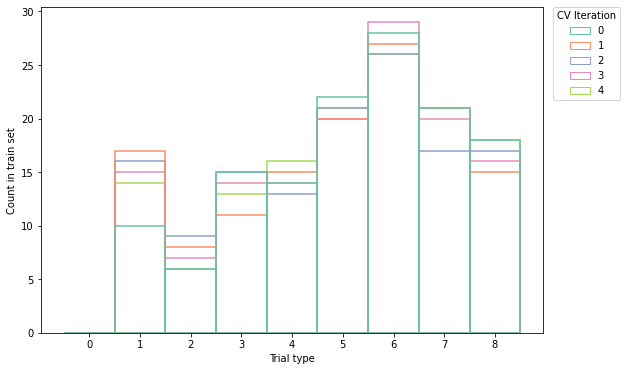

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

def move_legend(ax, new_title, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    if new_title is not None:
        title = new_title
    else:
        title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

g = sns.histplot(data=df, x='trial_type', hue='cv_iter', element='bars', fill=False, binwidth=1, binrange=(0, 8), discrete=True,
                 palette='Set2', ax=ax)
g.set_xticks(range(9))
move_legend(ax, new_title='CV Iteration', bbox_to_anchor=(1.02, 1), new_loc=2, borderaxespad=0.)
ax.set_xlabel('Trial type')
ax.set_ylabel('Count in train set');